In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt, colors
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error, make_scorer, rand_score, accuracy_score
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.neural_network import MLPClassifier
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch import Tensor

In [2]:
data = pd.read_csv('wdbc.data', header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


***ЗАДАНИЕ 1***

Разработать 3 классификатора и осуществить настройку их параметров для минимизации ошибки классификации на тестовых данных. Выполнить визуализацию данных при помощи метода t-SNE.

**1.1. SVM**

In [3]:
X = X_scaled = pd.DataFrame(StandardScaler().fit_transform(data.drop(1, axis=1)))

y = data[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [163]:
svm_clf = SVC(kernel='linear', max_iter=100000, C=15)
params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': np.arange(0.001, 0.01, 0.001), 'C': [4, 5, 6, 7, 8]}
gs = GridSearchCV(svm_clf, params, n_jobs=-1)
gs.fit(X_train, y_train)
gs.best_estimator_, gs.best_score_
#svm_clf.fit(X_train, y_train)
#svm_clf.score(X_test, y_test)

(SVC(C=4, gamma=0.005, max_iter=100000), 0.9780219780219781)

In [164]:
svm_clf = gs.best_estimator_
svm_clf.score(X_test, y_test)

0.9824561403508771

**1.2. Бустинг**

In [9]:
boost_clf = AdaBoostClassifier()
trees = [DecisionTreeClassifier(max_depth=i) for i in range(6)]

params = {'n_estimators': range(20, 136, 5), 'base_estimator': trees}
gs = GridSearchCV(boost_clf, params, n_jobs=-1)
gs.fit(X_train, y_train)
gs.best_estimator_, gs.best_score_
#clf.fit(X_train, y_train)
#clf.score(X_test, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.97362637 0.96043956 0.95824176 0.95604396 0.95824176 0.96923077
 0.95824176 0.96043956 0.96263736 0.96483516 0.96263736 0.96263736
 0.96923077 0.96923077 0.96923077 0.96703297 0.96703297 0.96923077
 0.96483516 0.96483516 0.96703297 0.96703297 0.96703297 0.96923077
 0.94725275 0.95164835 0.94065934 0.95384615 0.94285714 0.95164835
 0.95604396 0.96043956 0.95604396 0.95824176 0.96263736 0.96263736
 0.95604396 0.95824176 0.96043956 0.96483516 0.96483516 0.95824176
 0.96043956 0.96483516 0.96263736 0.96703297 0.96263736 0.96263736
 0.95384615 0.94285714 0.95164835 0.95824176 0.951648

(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                    n_estimators=20),
 0.9736263736263737)

In [10]:
boost_clf = gs.best_estimator_
boost_clf.score(X_test, y_test)

0.9385964912280702

**1.3 Нейронная сеть**

In [168]:
nn_clf = MLPClassifier(hidden_layer_sizes=(4, ), activation='tanh', solver='adam', batch_size=4, max_iter=500)
nn_clf.fit(X_train, y_train)
nn_clf.score(X_test, y_test)

0.9736842105263158

*это очень странно, но оказалось достаточно 4х нейронов на скрытом слое, чтобы достигнуть (видимо) предела*

**Визуализация**

In [169]:
tsne = TSNE()
X_embedded = tsne.fit_transform(X)

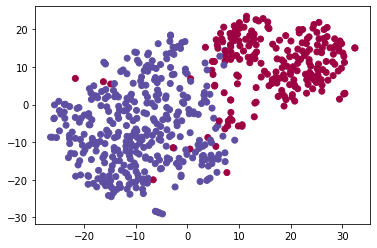

In [170]:
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, 2)]
cs = [colors[0] if y[i] == 'M' else colors[1] for i in range(len(y))] # ужасный код, пожалуйста, сделайте вид, что Вы его не видели
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=cs)

***ЗАДАНИЕ 2***

Сравнить классификаторы (по критерию вероятность ошибки классификации для тестовых данных) и обосновать выбор наилучшего из них.

Эмпирическим путем установлено, что лучшим классификатором (по вероятности ошибки на тестовой выборке) оказался SVM с ядром rbf. 

Примечательно, что нейронная сеть всего с 4 нейронами на скрытом слое показала хорошие результаты. 

Сеть с 4 нейронами на скрытом слое представляет собой стэкинг четырех логистических регрессий с tanh вместо сигмоиды (это базовые классификаторы), которые передаются в еще одну такую же логистическую регрессию, вычисляющую выход модели. Таким образом, сеть с 4 нейронами на скрытом слое является достаточно сложной структурой с большим числом параметров (по сравнению с прочими моделями)

***ЗАДАНИЕ 3***

Удалить из базы метки классов и осуществить кластеризацию данных. Построить дендограмму. Сравнить полученные результаты с реальными метками данных. Определить долю ошибочно кластеризованных данных. 

In [4]:
kmeans = KMeans(n_clusters=2, algorithm='elkan')
y_pred = kmeans.fit_predict(X)
y_nums = LabelEncoder().fit_transform(y)
accuracy_score(y_nums, y_pred)

0.9103690685413005

In [5]:
def plot_dendrogram(model, **kwargs):
    # Создайте матрицу связей, а затем постройте дендрограмму

    # создаем количество выборок под каждым узлом
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # листовой узел
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Постройте соответствующую дендрограмму
    dendrogram(linkage_matrix, **kwargs)

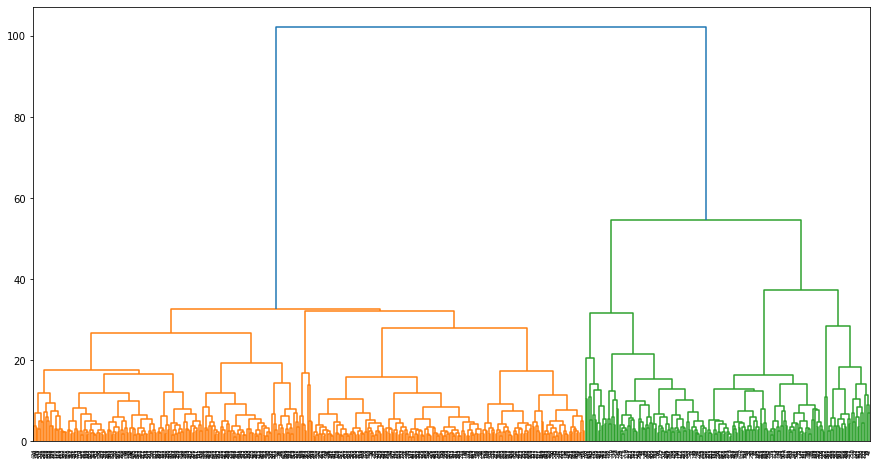

In [9]:
fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(8)
plot_dendrogram(AgglomerativeClustering(n_clusters=2, compute_distances=True).fit(X), ax=ax)

***ЗАДАНИЕ 4***

Используя логистическую регрессию в рамках метода Лассо, определить наиболее значимые признаки, влияющие на отнесение объектов к определенному классу.

In [12]:
model = LogisticRegression(penalty='l1', solver='saga', max_iter=6000)
model.fit(X, y)

LogisticRegression(max_iter=6000, penalty='l1', solver='saga')

array([0.09045869, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.10413627, 1.1017114 , 0.        ,
       0.14131707, 2.71067638, 0.3640684 , 0.        , 0.        ,
       0.26676136, 0.89266188, 0.        , 0.        , 0.        ,
       0.23270653, 1.94933572, 1.76853646, 0.60800591, 1.78379757,
       0.55831988, 0.        , 1.1308768 , 1.21715107, 0.5522589 ,
       0.        ])

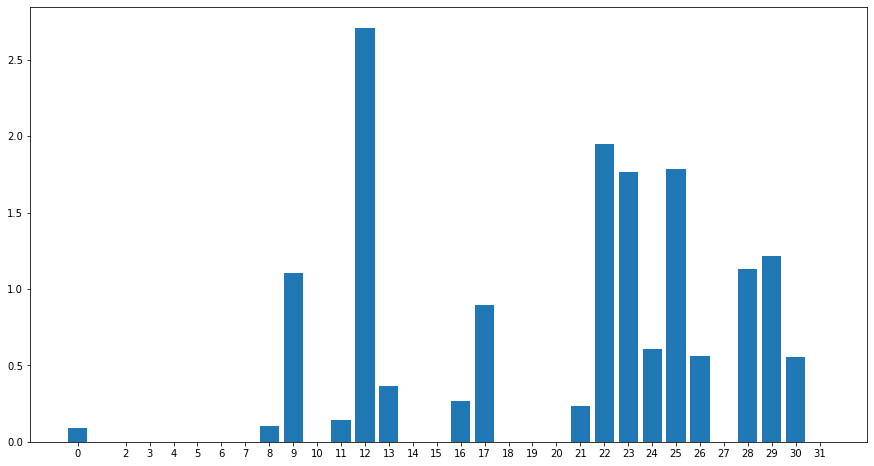

In [8]:
fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(8)
ax.bar(data.drop(1, axis=1).columns, np.abs(model.coef_[0]))
ax.xaxis.set_ticks([0] + [ i for i in range(2, 32)])
np.abs(model.coef_[0])

In [16]:
model.score(X, y)

0.9876977152899824